In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import re

In [3]:
# Mute warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
train_df=pd.read_csv('d:/kaggle/Titanic/train.csv')
test_df=pd.read_csv('d:/kaggle/Titanic/test.csv')

In [42]:
train_df['train_test'] = 1
test_df['train_test'] = 0
test_df['Survived'] = np.NaN
all_data = pd.concat([train_df,test_df])
%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [43]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [44]:
all_data['Title'] = all_data['Name'].apply(get_title)
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

In [45]:
all_data['Title'] = all_data['Title'].replace(
       ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
       'Rare')

In [46]:
all_data.Age = all_data.Age.fillna(train_df.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(train_df.Fare.median())

In [10]:
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)

In [11]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])

In [12]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Title,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,0,0,n
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,0,1,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,0,0,n
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,1,1,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,1,0,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,NaN,S,0,Mr,0,0,n
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,Rare,0,1,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,Mr,0,0,n
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,NaN,S,0,Mr,1,0,n


In [13]:
data=all_data

In [14]:
data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [15]:
data['Embarked'] = data['Embarked'].replace('S', 1)
data['Embarked'] = data['Embarked'].replace('C', 2)
data['Embarked'] = data['Embarked'].replace('Q', 3)

In [16]:
data.cabin_adv.value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin_adv, dtype: int64

In [17]:
data['cabin_adv'] = data['cabin_adv'].replace('n', 1)
data['cabin_adv'] = data['cabin_adv'].replace('C', 2)
data['cabin_adv'] = data['cabin_adv'].replace('B', 3)
data['cabin_adv'] = data['cabin_adv'].replace('D', 4)
data['cabin_adv'] = data['cabin_adv'].replace('E', 5)
data['cabin_adv'] = data['cabin_adv'].replace('A', 6)
data['cabin_adv'] = data['cabin_adv'].replace('F', 7)
data['cabin_adv'] = data['cabin_adv'].replace('G', 8)
data['cabin_adv'] = data['cabin_adv'].replace('T', 9)

In [18]:
data['Sex'] = data['Sex'].replace('male', 1)
data['Sex'] = data['Sex'].replace('female', 2)

In [19]:
data.Title.value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [20]:
data['Title'] = data['Title'].replace('Mr', 1)
data['Title'] = data['Title'].replace('Miss', 2)
data['Title'] = data['Title'].replace('Mrs', 3)
data['Title'] = data['Title'].replace('Master', 4)
data['Title'] = data['Title'].replace('Rare', 5)

In [21]:
data=data.drop(['Name','Ticket','Title','Cabin'], axis =1)

In [22]:
data.isna().sum().sort_values(ascending=False)

Survived          418
Embarked            2
PassengerId         0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Fare                0
train_test          0
numeric_ticket      0
cabin_multiple      0
cabin_adv           0
dtype: int64

In [23]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = data.copy()

In [24]:
all_dummies_scaled 

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train_test,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,3,1,22.0,1,0,7.2500,1.0,1,0,0,1
1,2,1.0,1,2,38.0,1,0,71.2833,2.0,1,0,1,2
2,3,1.0,3,2,26.0,0,0,7.9250,1.0,1,0,0,1
3,4,1.0,1,2,35.0,1,0,53.1000,1.0,1,1,1,2
4,5,0.0,3,1,35.0,0,0,8.0500,1.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,28.0,0,0,8.0500,1.0,0,0,0,1
414,1306,NaN,1,2,39.0,0,0,108.9000,2.0,0,0,1,2
415,1307,NaN,3,1,38.5,0,0,7.2500,1.0,0,0,0,1
416,1308,NaN,3,1,28.0,0,0,8.0500,1.0,0,1,0,1


In [25]:
all_dummies_scaled[['Pclass','Sex','SibSp','Embarked','Parch','Age','Fare','cabin_adv']]= scale.fit_transform(all_dummies_scaled[['Pclass','Sex','SibSp','Embarked','Parch','Age','Fare','cabin_adv']])
all_dummies_scaled

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,train_test,numeric_ticket,cabin_multiple,cabin_adv
0,1,0.0,0.841916,-0.743497,-0.581628,0.481288,-0.445000,-0.503291,-0.604066,1,0,0,-0.441136
1,2,1.0,-1.546098,1.344995,0.658652,0.481288,-0.445000,0.734744,0.926000,1,0,1,0.276189
2,3,1.0,0.841916,1.344995,-0.271558,-0.479087,-0.445000,-0.490240,-0.604066,1,0,0,-0.441136
3,4,1.0,-1.546098,1.344995,0.426099,0.481288,-0.445000,0.383183,-0.604066,1,1,1,0.276189
4,5,0.0,0.841916,-0.743497,0.426099,-0.479087,-0.445000,-0.487824,-0.604066,1,1,0,-0.441136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0.841916,-0.743497,-0.116523,-0.479087,-0.445000,-0.487824,-0.604066,0,0,0,-0.441136
414,1306,NaN,-1.546098,1.344995,0.736169,-0.479087,-0.445000,1.462034,0.926000,0,0,1,0.276189
415,1307,NaN,0.841916,-0.743497,0.697411,-0.479087,-0.445000,-0.503291,-0.604066,0,0,0,-0.441136
416,1308,NaN,0.841916,-0.743497,-0.116523,-0.479087,-0.445000,-0.487824,-0.604066,0,1,0,-0.441136


In [26]:
all_dummies_scaled=all_dummies_scaled.drop(['PassengerId','Survived'], axis =1)

In [27]:
all_dummies_scaled=all_dummies_scaled.drop(['Embarked'], axis =1)

In [28]:
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [29]:
X_train_scaled

,Pclass,Sex,Age,SibSp,Parch,Fare,numeric_ticket,cabin_multiple,cabin_adv
0,0.841916,-0.743497,-0.581628,0.481288,-0.445000,-0.503291,0,0,-0.441136
1,-1.546098,1.344995,0.658652,0.481288,-0.445000,0.734744,0,1,0.276189
2,0.841916,1.344995,-0.271558,-0.479087,-0.445000,-0.490240,0,0,-0.441136
3,-1.546098,1.344995,0.426099,0.481288,-0.445000,0.383183,1,1,0.276189
4,0.841916,-0.743497,0.426099,-0.479087,-0.445000,-0.487824,1,0,-0.441136
...,...,...,...,...,...,...,...,...,...
886,-0.352091,-0.743497,-0.194041,-0.479087,-0.445000,-0.392119,1,0,-0.441136
887,-1.546098,1.344995,-0.814181,-0.479087,-0.445000,-0.063437,1,1,0.993514
888,0.841916,1.344995,-0.116523,0.481288,1.866526,-0.190076,0,0,-0.441136
889,-1.546098,-0.743497,-0.271558,-0.479087,-0.445000,-0.063437,1,1,0.276189


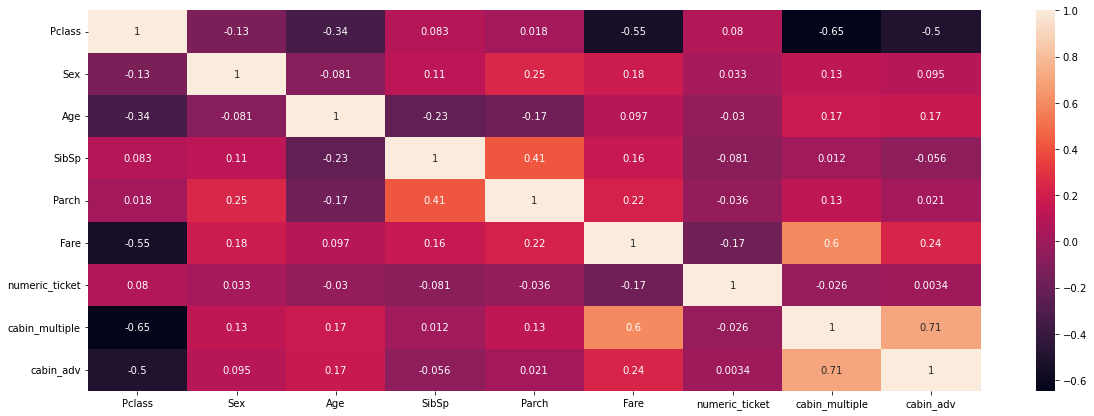

In [39]:
numeric_corr = X_train_scaled.corr()
plt.figure(figsize = (20,7))
sns.heatmap(numeric_corr, annot = True);

In [30]:
X_train_scaled.isna().sum().sort_values(ascending=False)

Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
numeric_ticket    0
cabin_multiple    0
cabin_adv         0
dtype: int64

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [32]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.72067039 0.73033708 0.79213483 0.7752809  0.80898876]
0.765482392819032


In [33]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79888268 0.79775281 0.79213483 0.76966292 0.81460674]
0.7946079969870065


In [34]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.70949721 0.74157303 0.84831461 0.73595506 0.84831461]
0.7767309020149394


In [35]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77094972 0.78651685 0.81460674 0.79775281 0.83707865]
0.8013809553700332


In [36]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77094972 0.80337079 0.87640449 0.75842697 0.84269663]
0.810369719414977


In [37]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.79775281 0.82022472 0.80898876 0.84831461]
0.8204193082669009


In [38]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.80337079 0.85955056 0.80337079 0.83146067]
0.8182097796748478


In [46]:
k_range = range(1,31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn,X_train_scaled,y_train,cv=10)
    k_scores.append(scores.mean())

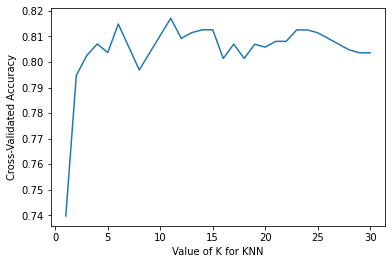

In [47]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [40]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [41]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.80898876 0.85955056 0.79775281 0.84269663]
0.8204569706860838


In [49]:
#voting_clf.fit(X_train_scaled,y_train)
#y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
#basic_submission = {'PassengerId': test_df.PassengerId, 'Survived': y_hat_base_vc}
#base_submission = pd.DataFrame(data=basic_submission)
#base_submission.to_csv('base_submission.csv', index=False)